
LavaVu: python API quickstart guide
---
The LavaVu python interface provides a python style, object oriented way of working with 4D visualisations. All the objects you work with have properties that control how the visualisation is rendered which can be added, read or modified like a python dictionary. 

The Viewer Object
---

The first object you need to create is the Viewer() which defines a viewing frame and an OpenGL rendering context. Using this we can then create drawing objects that can then be used to load rendering data.

Properties set on the Viewer control the global rendering state as well as the highest level scope for setting object properties. They are listed on the wiki here by category:
https://github.com/OKaluza/LavaVu/wiki/Property-Reference

Other actions that change the visualisation are possible via functions on the viewer object or the drawing objects.
These include the set of scripting commands understood by LavaVu which are listed here
https://github.com/OKaluza/LavaVu/wiki/Scripting-Commands-Reference

These can be called as methods on the Viewer object, eg: lv.rotate('x', 90)

#### Create a viewer

Additionally, let's set the background and resolution by passing them to the constructor

In [17]:
import lavavu
lv = lavavu.Viewer(background="white", resolution=(400,300))

Images and video can be created from the viewer as well as opening interactive views.
If running in an IPython notebook, images and video can be displayed inline.


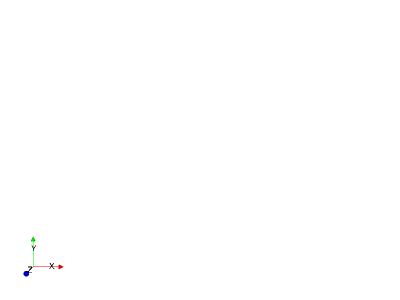

'output.png'

In [18]:
#Save an image inline
lv.display()

#Save an image to disk, optionally at a different resolution
lv.image("output.png", resolution=(500,500))

In [19]:
lv["opacity"] = 0.5

#### Creating objects

Objects associate a set of rendering properties with a collection of rendering data (vertices etc)

Available object creation functions are:
  **points, lines, triangles, quads, shapes, vectors, tracers, volume, labels**


In [20]:
pts = lv.points("myparticles") #, pointsize=10)

In [21]:
surf = lv.triangles("mymesh")

surf["opacity"] = 1.0

#### Load some data
This can be in a python list or for numerical data - a numpy array or anything that can be trivially converted to a numpy array

In [22]:
pts.vertices([[0,0,1], [1,1,1], [0,1,1], [1,0,1]])
surf.vertices([[0,0.25,0], [1,0,1], [1,0.75,0], [0,0.25,1], [0.5,0.5,0.5]])
surf.indices([[0,2,4], [4,2,1], [0,4,3], [3,4,1]])


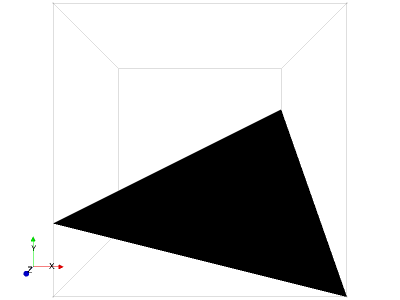

In [23]:
lv.reload() #Because we have new data since last display
lv.display()

Functions for data loading expect either scalar (1d) or vector (3d) data.

Most functions expect floating point values, all of which will be converted to 32 bit single precision.

3d vector data is interpreted as a list of coord triples [[x0,y0,z0], [x1, y1, z1]...] 
If passed split coord arrays arrange in a list/array [[x0,x1...], [y0, y1...], [z0, z1...]] this will be detected automatically if the first dimension of the passed array is 3 and the last dimension is != 3, the array will be reshaped before loading.

Available data loading functions are:
 - **vertices**: 3d vertex data, float. The vertices to plot.
 - **normals**: 3d normal data, float. normals for meshes, if not provided will be calculated automatically
 - **vectors**: 3d vector data, float. Vector field data.
 - **indices**: integer index data referencing the indices of vertices to use for plotting, when provided will lookup vertices to plot from this array instead of just plotting them in their memory order
 - **colours**: either 32 bit integer data defining an array of ARGB colours or a list of strings that will be parsed as colours. Colour strings can be either names from https://en.wikipedia.org/wiki/X11_color_names (with spaces removed) or HTML style colour values in either hex "#RRGGBB" or decimal "rgb(R,G,B)" or "rgba(R,G,B,A)"
 - **labels**: string data to label vertices
 - **values**: scalar data, this function has an additional label argument to name the data as multiple scalar fields can be loaded under different labels.
 - **texcoords**: 2d texture coord data, float. Coordinates to map texture to a mesh.
 - **rgb**: colour data as 8 bit integer array [r0,g0,b0, r1,g1.b1,....]
 - **luminance**: luminance values as 8 bit integer array 

#### Loading additional data arrays
Here we'll colour our two objects in two different ways


In [24]:
pts.colours(["red", "blue"])

surf.values([0.25, 0, 0.75, 0.25, 0.5], "height")
cm = surf.colourmap("diverge")

In the first instance we load a literal colour value for each vertex. As there are not enough values for each vertex, they are spread over the range evenly, so each colour is applied to two vertices.

In the second, we provide an additional data field containing the height of each vertex (y coord) and then apply a colour map.

The label *height* we apply to the field can be used to switch between which field to use to colour the data, this is defined by the "colourby" property and defaults to the first scalar value data set loaded.
For example, to load and switch to colouring by a new field named *temperature*

    surf.values("temperatue", [20, 16, 27, 18])
    surf["colourby"] = "temperature"
   
The colourmap() function will apply a colourmap to an object to map the values of the field to colours, the data passed can be:

A name of a predefined colourmap, see: https://github.com/OKaluza/LavaVu/blob/master/notebooks/ColourMaps.ipynb

    surf.colourmap("diverge")
    
A list of colour strings, these will be evenly spaced over the map:

    surf.colourmap("red green blue")
    
A list of colour positions and value strings:

    surf.colourmap([(0, "black"), (0.25, "yellow"), (1, "red")])
    
Colours can also include an alpha value for transparency, either by using the HTML rgba(R,G,B,A\[0,1\]) format or appending a colon and the alpha value to a hex or X11 colour name value.

    surf.colourmap("rgab(255,0,0,0.5) #0000ff:0.5")

The return value of colourmap() is a ColourMap object which can be used to later modify the colourmap:

In [25]:
#Set the opacity of the last colour to 0.0 (transparent)
cm.colours[-1][3] = 0.0

A colour bar can be plotted with the colourbar() function:

In [26]:
cb = surf.colourbar()


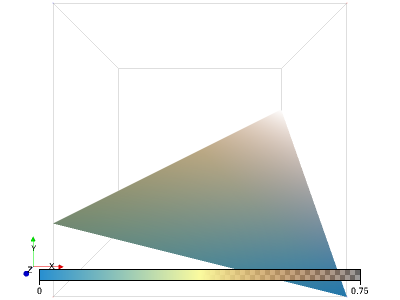

In [27]:
lv.reload() #Because we have new data since last display
lv.display()

More about properties
---
All the available properties are listed here:
https://github.com/OKaluza/LavaVu/wiki/Property-Reference

Properties can be passed as arguments to the function used to create the object or set using the python dictionary syntax afterwards.

Property values "cascade", meaning a property that is only defined on a specific type of object, can still be set at a broader scope (such as globally or on a timestep), where it will define a default value for all objects within that scope. If not set at any level the properties fall back to their default values.
Available scopes are: global, timestep, view, object, colourmap

More about geometry types
---
 - **points** : each vertex is a point
 - **lines**: each pair of vertices is a line, or if "link" property is true, each element block of vertices is a single joined line. Element blocks can be defined automatically by setting the "dims" property to a value [N] which will cause a new block to start once N vertices are loaded into the active one. Blocks of different sizes can be defined by calling the append() function on an object to explicitly start a new block.  
 - **triangles**: each vertex triple is a triangle, or if indices provided each index triple referencing the vertex array is a triangle. If "dims"=[width, height] is specified, instead plotted as a regular grid mesh where vertices are the grid points.
 - **quads**: Plots a regular grid as for triangles but using quads, requires "dims"=[width, height] to be set
 - **vectors**: Plots vector arrows at each vertex, requires a vector field to be loaded.
 - **tracers**: Plots tracer lines or arrows over time-varying point vertices.
 - **shapes**: Plots ellipsoids or cuboids at each vertex. Data fields or properties can be used to define their dimensions.
 - **volume**: Volume render a cube of data or a set of slices.
 - **labels**: as points, but the points are hidden to allow label data to be displayed without other geometry being plotted.

> NOTE: The function used to create the object only specifies how the
> subsequent data loaded will be rendered, the objects themselves are
> all the same. This can be changed after object creation with the
> "geometry" property, so to load a triangle mesh into our 'pts' object,
> we can set pts["geometry"] = "triangles" before loading the mesh data. Both the points and the mesh will be plotted with the properties of the pts object.


Time Varying data
---
When loading data, there is initially no time dimension defined. All geometry loaded at this point is considered fixed in time and will always be rendered.

To define a time step, call the addstep() function, properties can also be passed to this function which will apply to this timestep only:

    lv.addstep(title="1/1/2018")

All data subsequently loaded will be considered temporal and displayed only when its timestep is set to the active one:

In [30]:
falling = lv.points("falling", pointsize=20, pointtype="sphere", colour="green")

for time in range(0,20):
    lv.addstep(time)
    height = 1.0 - 0.05*time
    falling.vertices([0.5, height, 0.5])

Timestep information can also be retrieved and set as follows:

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Current timestep:  5



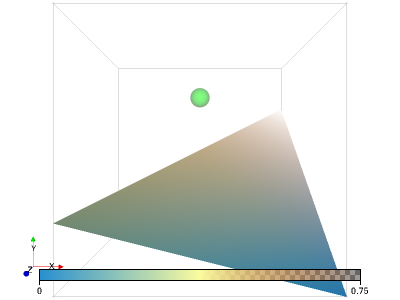

In [31]:
print(lv.steps)
lv.step = 5 #Attempt to set timestep 5 (if not found, nearest match will be selected)
print("Current timestep: ", lv["timestep"])
lv.display()

### Interaction
An inline interactive mode is provided for IPython notebooks where the interactive window is displayed inline within a cell. This operates in the background and python commands can continue to be issued.

Control widgets can also be created to interactively manipulate rendering properties from IPython, such as active timestep

An interactive window allows mouse control to adjust the viewpoint

In [ ]:
lv.control.TimeStepper()
lv.window()